In [1]:
from excel_reader import ExcelReader

In [2]:
from iv_calculator import calculate_iv_for_chain

In [3]:
import pandas as pd

In [4]:
import numpy as np

In [5]:
excel_reader = ExcelReader(
    excel_file="petr_options_chain.xlsx",
    sheet_name="Sheet1",
    iv_col="I",
    start_row=2,
    end_row=805,
    bid_col="E",
    ask_col="F",
    last_price_col="B",
    strike_col="C",
    open_interest_col="H",
    volume_col="D",
    ticker_col="A",
    maturity_col="G",
    spot_price_col="J"
)

In [6]:
with_forward = excel_reader.add_forward_price()

In [7]:
with_forward

,bid,ask,lastPrice,Strike,openInterest,volume,ticker,Expiry,IV,SpotPrice,Type,DaysToExpiry,TimeToExpiry,Forward
0,19.32,19.96,20.28,10.92,62800.0,300.0,PETRJ115,17/10/2025,4.334297,30.6,call,7,0.027778,59.629200
1,0.00,0.00,0.00,11.17,0.0,0.0,PETRJ117,17/10/2025,0.000000,30.6,call,7,0.027778,59.629200
2,18.82,19.47,19.75,11.42,35400.0,200.0,PETRJ120,17/10/2025,4.087601,30.6,call,7,0.027778,59.629200
3,0.00,0.00,0.00,11.67,0.0,0.0,PETRJ122,17/10/2025,0.000000,30.6,call,7,0.027778,59.629200
4,18.32,18.97,19.61,11.92,600.0,400.0,PETRJ125,17/10/2025,4.658432,30.6,call,7,0.027778,59.629200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799,0.00,0.00,0.00,39.40,0.0,0.0,PETRW394W1,07/11/2025,0.000000,30.6,put,22,0.087302,56.529425
800,0.00,0.00,0.00,39.40,0.0,0.0,PETRW394W2,14/11/2025,0.000000,30.6,put,27,0.107143,55.571549
801,0.00,0.00,0.00,39.90,0.0,0.0,PETRW399W1,07/11/2025,0.000000,30.6,put,22,0.087302,56.529425
802,0.00,0.00,0.00,39.90,0.0,0.0,PETRW399W2,14/11/2025,0.000000,30.6,put,27,0.107143,55.571549


In [8]:
result = calculate_iv_for_chain(with_forward, 0.15, min_volume=100, max_rel_spread=0.5, min_days_expiry=2)

In [9]:
result

,TimeToExpiry,Strike,ImpliedVolatility,Type,Forward
60,0.027778,23.47,1.091725,call,59.629200
62,0.027778,23.72,1.021308,call,59.629200
63,0.027778,23.97,1.003244,call,59.629200
65,0.027778,24.22,0.968003,call,59.629200
66,0.007937,24.40,1.323869,call,60.742722
...,...,...,...,...,...
521,0.007937,30.65,0.148799,put,60.742722
522,0.027778,30.72,0.176712,put,59.629200
526,0.027778,29.47,0.224017,put,59.629200
532,0.027778,29.97,0.203716,put,59.629200


In [10]:
from data_formatter import format_options_data_to_dict
formatted_data = format_options_data_to_dict(result, strike_col='Strike', iv_col='ImpliedVolatility', tte_col='TimeToExpiry', forward_col='Forward')

In [ ]:
formatted_data['call']

{0.027777777777777776:     Strike  ImpliedVolatility  Forward
 0    23.47           1.091725  59.6292
 1    23.72           1.021308  59.6292
 2    23.97           1.003244  59.6292
 3    24.22           0.968003  59.6292
 4    24.47           0.933025  59.6292
 5    24.72           0.890348  59.6292
 6    24.97           0.856032  59.6292
 7    25.22           0.821940  59.6292
 8    25.47           0.788055  59.6292
 9    25.72           0.731786  59.6292
 10   25.97           0.706335  59.6292
 11   26.22           0.720617  59.6292
 12   26.47           0.698672  59.6292
 13   26.72           0.664304  59.6292
 14   26.97           0.630012  59.6292
 15   27.22           0.601219  59.6292
 16   27.47           0.572022  59.6292
 17   27.72           0.537418  59.6292
 18   27.97           0.507537  59.6292
 19   28.22           0.477122  59.6292
 20   28.47           0.446108  59.6292
 21   28.72           0.418485  59.6292
 22   28.97           0.389614  59.6292
 23   29.22       

In [15]:
print(strikes, market_iv)

[24.4  24.9  25.4  25.9  26.4  26.9  27.4  27.9  28.4  28.9  29.4  29.65
 29.9  30.15 30.4  30.65 30.9  31.15 31.4 ] [1.32386936 1.24933146 1.21846703 1.40418805 1.29107208 1.16612707
 1.05113768 0.92492201 0.80579844 0.67513652 0.55362461 0.49511785
 0.43207366 0.37353876 0.32862245 0.30148143 0.27401769 0.26177507
 0.26380768]


In [14]:
for ttm, df_slice in formatted_data['call'].items():
    if len(df_slice) < 5: # Need sufficient points to fit 5 parameters
        print(f"Skipping TTM={ttm:.4f} due to insufficient data points ({len(df_slice)}).")
        continue

    print(f"Calibrating for TTM = {ttm:.4f} years...")
    forward_price = df_slice['Forward'].iloc[0]
    strikes = df_slice['Strike'].values
    market_iv = df_slice['ImpliedVolatility'].values

    # Avoid issues with zero/infinite moneyness if F or K is zero
    valid_indices = (strikes > 1e-6) & (forward_price > 1e-6)
    if not np.any(valid_indices):
        print(f"Skipping TTM={ttm:.4f} due to invalid strike/forward prices.")
        continue

    strikes = strikes[valid_indices]
    market_iv = market_iv[valid_indices]

Calibrating for TTM = 0.0278 years...
Calibrating for TTM = 0.0079 years...


In [ ]:
# from cubic_interpolation import interpolate_volatility_surface, plot_interpolated_surface

ModuleNotFoundError: No module named 'vol_lib'

In [ ]:
# TICKER_SYMBOL: str = "AAPL" # Default ticker, can be overridden by environment variable
# RISK_FREE_RATE: float = 0.15 # Example risk-free rate (annualized)
# # Filter thresholds for option data cleaning
# MIN_VOLUME: int = 100
# MAX_REL_SPREAD: float = 0.50 # Maximum relative spread (Spread / MidPrice)
# MIN_DAYS_TO_EXPIRY: int = 1 # Minimum days to expiry to include
# MIN_IV: float = 0.01 # Minimum plausible IV
# MAX_IV: float = 4.00 # Maximum plausible IV
# # Interpolation Grid Resolution
# N_STRIKES_GRID: int = 100
# N_EXPIRIES_GRID: int = 100
# INTERPOLATION_METHOD: str = 'cubic' # 'linear' or 'cubic'

In [ ]:
# print(f"\nInterpolating the volatility surface using '{INTERPOLATION_METHOD}' method...")
# T_grid, K_grid, iv_surface_interpolated = interpolate_volatility_surface(
#     iv_data=result,
#     method=INTERPOLATION_METHOD,
#     n_strikes=N_STRIKES_GRID,
#     n_expiries=N_EXPIRIES_GRID
# )


Interpolating the volatility surface using 'cubic' method...


Plotting the interpolated surface...

--- Script execution finished ---


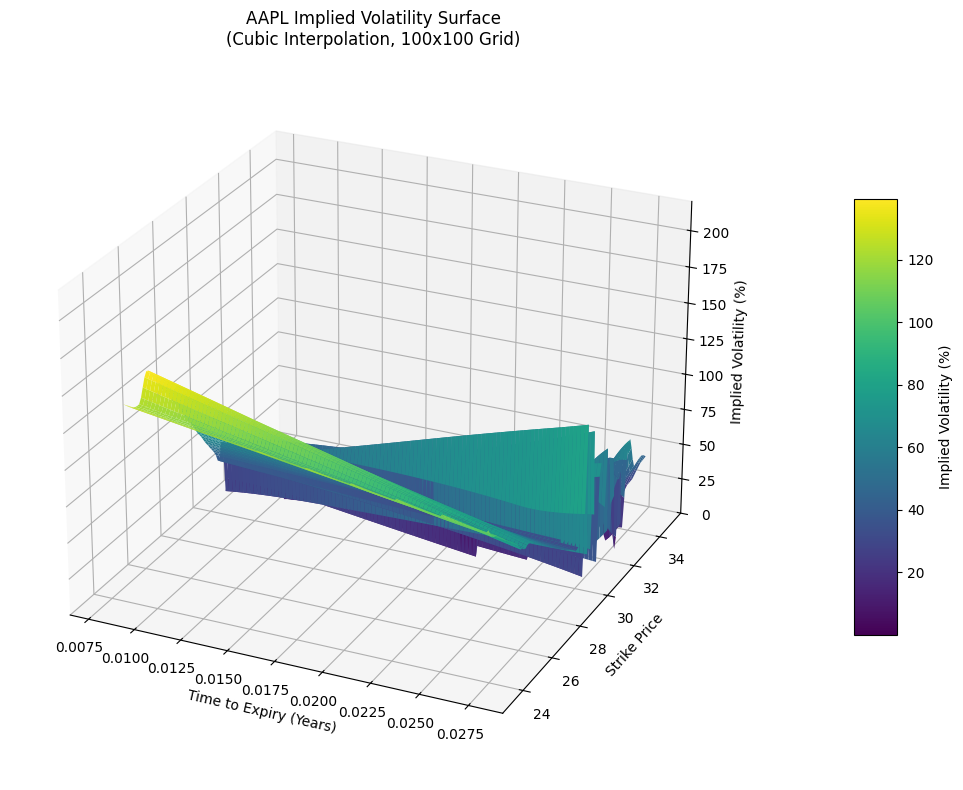

In [ ]:
# if T_grid.size > 0: # Check if interpolation produced a grid
#     print("Plotting the interpolated surface...")
#     plot_title = (f"{TICKER_SYMBOL} Implied Volatility Surface\n"
#                     f"({INTERPOLATION_METHOD.capitalize()} Interpolation, "
#                     f"{N_EXPIRIES_GRID}x{N_STRIKES_GRID} Grid)")
#     plot_interpolated_surface(
#         T_grid,
#         K_grid,
#         iv_surface_interpolated,
#         filename="plot.png",
#         title=plot_title
#     )
# else:
#     print("Interpolation failed or yielded no usable grid. Cannot plot surface.")
#     # Ensure plot file is created even if interpolation failed
#     plot_interpolated_surface(np.array([]), np.array([]), np.array([]), filename='plot.png', title=f"{TICKER_SYMBOL} IV Surface (Interpolation Failed)")

# print("\n--- Script execution finished ---")